In [16]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
# Locate repo root so imports from src work even if notebook moves
while PROJECT_ROOT != PROJECT_ROOT.parent and not (PROJECT_ROOT / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

if not (PROJECT_ROOT / 'src').exists():
    raise RuntimeError("Could not locate 'src' directory relative to this notebook")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


# Cost Gap vs Horizon Length


We compare the offline optimal controller against EGPC under bursty arrivals
for several horizon lengths `T`. The cost gap is the total cost difference
`EGPC - optimal`.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from src.offline_opt import solve_optimal_w
from src.simulate_storage_dynamics import simulate_storage_dynamics
from src.egpc import run_egpc

plt.style.use('seaborn-v0_8')

In [ ]:
Ts = [200, 400, 600, 800, 1000, 1500, 2000, 3000]
H = 50
kappa = 0.02
a_mode = 'bursty'

cost_key = 'weighted'
L = 4 + 0.1/kappa


results = []

for T in Ts:
    eta = np.sqrt(np.log(H)/T/(1/2 + 1/kappa))/L
    
    print(f"=== Solving for T={T} ===")
    opt_data = solve_optimal_w(a_mode=a_mode, cost_key=cost_key, H=H, T=T)
    opt_sim = simulate_storage_dynamics(
        opt_data['Phi'],
        opt_data['Psi'],
        opt_data['a'],
        opt_data['w_star'],
        cost_fn=opt_data['cost_fn'],
        cost_kwargs=opt_data['cost_kwargs'],
    )
    egpc_result = run_egpc(
        a_mode=a_mode,
        cost_key=cost_key,
        eta=eta,
        H=H,
        T=T,
        kappa=kappa,
        cost_kwargs=opt_data['cost_kwargs'],
    )
    results.append({
        'T': T,
        'opt_total': opt_sim['total_cost'],
        'egpc_total': egpc_result['total_cost'],
        'diff': egpc_result['total_cost'] - opt_sim['total_cost'],
    })

=== Solving for T=200 ===

──────────────────────────────
Optimal weight vector found for 'bursty' | cost='weighted'
Objective value: 263.5907
w* (rounded): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Sum(w*): 1.0000
──────────────────────────────
=== Solving for T=400 ===

──────────────────────────────
Optimal weight vector found for 'bursty' | cost='weighted'
Objective value: 531.4693
w* (rounded): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Sum(w*): 1.0000
──────────────────────────────
=== Solving for T=600 ===

──────────────────────────────
Optimal weight vector found for 'bursty' | cost='weighted'
Objective value: 796.2914
w* (rounded): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
print(f"{'T':>6} | {'opt_total':>12} | {'egpc_total':>12} | {'diff':>12}")
print('-' * 55)
for row in results:
    print(f"{row['T']:6d} | {row['opt_total']:12.3f} | {row['egpc_total']:12.3f} | {row['diff']:12.3f}")

     T |    opt_total |   egpc_total |         diff
-------------------------------------------------------
   200 |      263.591 |      333.052 |       69.462
   400 |      531.469 |      660.530 |      129.061
   600 |      796.291 |     1004.131 |      207.839
   800 |     1096.573 |     1351.452 |      254.879
  1000 |     1408.599 |     1686.805 |      278.207
  1500 |     2069.387 |     2502.795 |      433.407
  2000 |     2813.369 |     3348.889 |      535.521
  3000 |     3982.153 |     4892.584 |      910.430


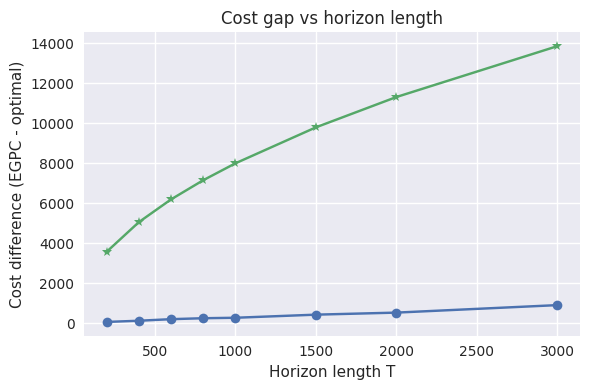

In [ ]:
Ts_vals = [row['T'] for row in results]
diffs = [row['diff'] for row in results]

plt.figure(figsize=(6, 4))
plt.plot(Ts_vals, diffs, marker='o')
    

plt.plot(Ts_vals, 2*L*np.sqrt(np.log(H)*np.array(Ts_vals)*(1/2 + 1/kappa)), marker='*')
plt.xlabel('Horizon length T')
plt.ylabel('Cost difference (EGPC - optimal)')
plt.title('Cost gap vs horizon length')
plt.grid(True)
plt.tight_layout()
plt.show()